# Ejercicio
Predecir el precio de un piso en función de la superficie construida y el distrito

In [2]:
#!pip install --upgrade typing-extensions

In [3]:
#!pip install gradio

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('pisos_huge.csv')
df.head()

,superficie_construida,precio,distritos_id
0,600,5400000,10
1,600,3800000,10
2,59,330000,9
3,63,402000,8
4,300,1750000,10


## EDA (Exploratory Data Analisis)

In [6]:
# Cantidad de nulos de cada variable
df.isnull().sum()

superficie_construida    0
precio                   0
distritos_id             0
dtype: int64

In [7]:
# Valores únicos de distritos_id
df['distritos_id'].unique()

array([10,  9,  8,  7,  4, 17, 12, 14, 35,  1, 11, 15, 16, 21, 13, 22, 20,
       18, 24, 25])

In [8]:
# Información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68597 entries, 0 to 68596
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   superficie_construida  68597 non-null  int64
 1   precio                 68597 non-null  int64
 2   distritos_id           68597 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


In [9]:
# X son las características (superficie_construida y distritos_id) e Y es lo que queremos predecir (precio) 
x = df[['superficie_construida', 'distritos_id']]
y = df['precio']

Creamos visualizaciónes para facilitar una exploración manual. Primero preparamos nuestros dataframes, lo dividimos en dos: un representará las características y el otro los precios:

In [10]:
# Correlación de Pearson
correlacion = df['superficie_construida'].corr(df['precio']) 
print('------- Correlación de Pearson m2 vs precio ------') 
print(correlacion)

------- Correlación de Pearson m2 vs precio ------
0.16751290350608766


En este caso la correrlación de Pearson da un valor de 0.805 que es bastante alto, indicando que el precio se relaciona bastante bien con el tamaño del inmueble, como suponíamos. Vamos a Crear un histograma para visualizar la distribución de 'precio' y 
'superficie_construida' en el mismo gráfico:

In [11]:
# Histograma para 'superficie_construida' en la misma escala
# Escalar la superficie para que sea comparable con el precio
scaled_superficie = df['superficie_construida'] * (df['precio'].max() / df['superficie_construida'].max())

(72.0, 488.1999999999971)

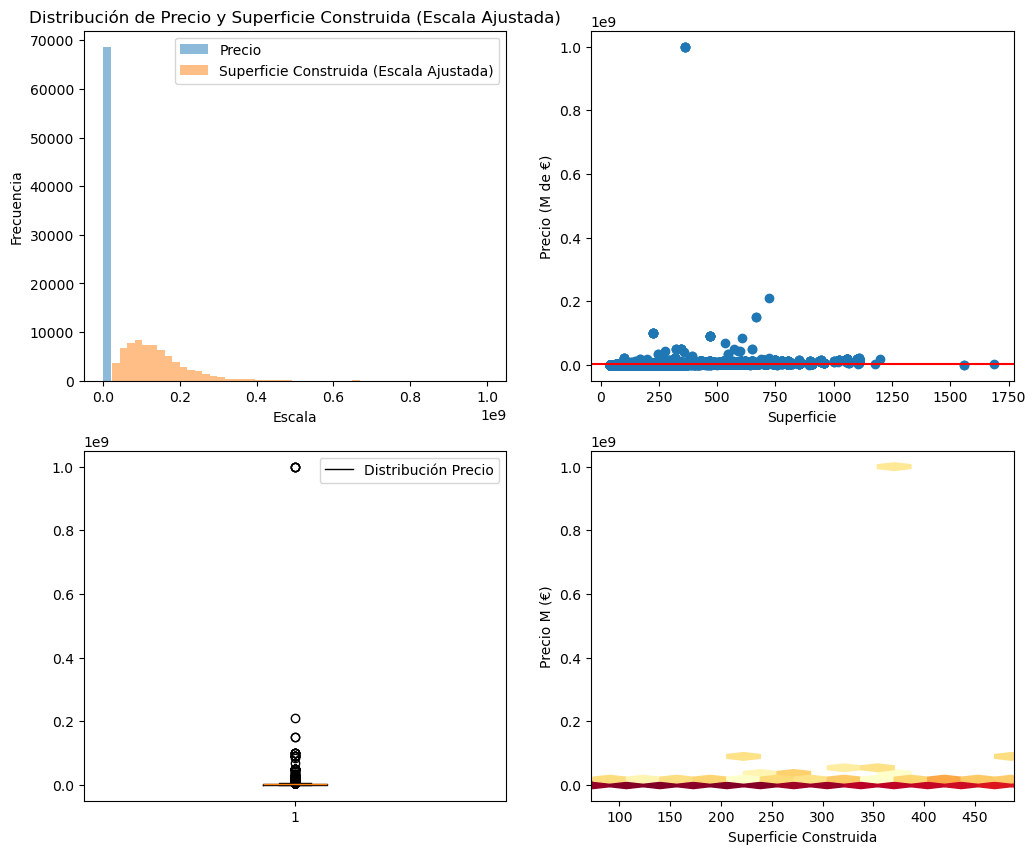

In [12]:
# Crea una figura y un conjunto de subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10)) # 2 filas, 2 columnas

# Primer gráfico: Histograma distribución de precios
axs[0, 0].hist(y, bins=50, alpha=0.5, label='Precio')
axs[0, 0].hist(scaled_superficie, bins=50, alpha=0.5, label='Superficie Construida (Escala Ajustada)') 
axs[0, 0].set_xlabel('Escala')
axs[0, 0].set_ylabel('Frecuencia')
axs[0, 0].set_title('Distribución de Precio y Superficie Construida (Escala Ajustada)') 
axs[0, 0].legend()

# Segundo gráfico: Scatter plot de superficie vs precio
# Definir los valores centrales (puede ser la media o la mediana)
centro_x = x['superficie_construida'].median()
centro_y = y.median()
axs[0, 1].scatter(x['superficie_construida'], y)
axs[0, 1].set_xlabel('Superficie')
axs[0, 1].set_ylabel('Precio (M de €)')
axs[0, 1].axhline(y=centro_y, color='r', linestyle='-') # Línea horizontal axs[0, 1].axvline(x=centro_x, color='r', linestyle='-') # Línea vertical

# Tercer gráfico con la distribución del precio
axs[1, 0].boxplot(y)
axs[1, 0].legend(['Distribución Precio'])

# Cuarto gráfico: hexagonal
# Histograma bidimensional
limite_inferior_x = df['superficie_construida'].quantile(0.05) 
limite_superior_x = df['superficie_construida'].quantile(0.95) 
limite_inferior_y = df['precio'].quantile(0.05)
limite_superior_y = df['precio'].quantile(0.95)
hb = axs[1, 1].hexbin(x['superficie_construida'], df['precio'], gridsize=50, cmap='YlOrRd', bins='log') 
axs[1, 1].set_xlabel('Superficie Construida')
axs[1, 1].set_ylabel('Precio M (€)')
axs[1, 1].set_xlim(limite_inferior_x, limite_superior_x)  # Ajustar según tus datos axs[1, 1].set_ylim(limite_inferior_y, limite_superior_y)

In [13]:
# Histograma bidimensional
limite_inferior_x = df['superficie_construida'].quantile(0.05) 
limite_superior_x = df['superficie_construida'].quantile(0.95) 
limite_inferior_y = df['precio'].quantile(0.05)
limite_superior_y = df['precio'].quantile(0.95)

## Modelo LinearRegression

### Paso 1: Lectura de datos

In [14]:
df_distritos = pd.read_csv('distritos.csv') # Nombres e ids de distrito
df_distritos.head()

,id,distrito
0,1,ARGANZUELA
1,4,CENTRO
2,7,SALAMANCA
3,8,CHAMARTIN
4,9,TETUAN


### Paso2: Prepración de variables

In [15]:
# X son las características (superficie_construida y distritos_id) e Y es lo que queremos predecir (precio) 
x = df[['superficie_construida', 'distritos_id']]
y = df['precio']

In [16]:
# Se añade una nueva columna al DataFrame que representa el precio por metro cuadrado

df['precio_m2'] = df['precio'] / df['superficie_construida']

### Paso 3: Limpieza de datos

Dado que ya hemos realizado el EDA, hemos visto que hay algunos valores atípicos que deforman bastante el gráfico. 
Se filtran los valores atípicos del precio por metro cuadrado usando los percentiles 1 y 99. Esto ayuda a mejorar la calidad de los datos eliminando los extremos.

In [17]:
# Eliminar valores atípicos usando el percentil 99 y 1 para precio m2
df = df[df['precio_m2'] < df['precio_m2'].quantile(0.99)] 
df = df[df['precio_m2'] > df['precio_m2'].quantile(0.01)]

In [18]:
# Con los datos limpios volvemos a reasignar x e y 
x = df[['superficie_construida', 'distritos_id']] 
y = df['precio']

### Paso 4: Normalización de Datos

**Normalización de la Superficie Construida**
- Se normaliza 'superficie_construida' restando la media y dividiendo por la desviación estándar. Esto coloca los datos en una escala común sin distorsionar las diferencias en los rangos de valores.

**Creación de Características Normalizadas**
- Se crea un nuevo DataFrame (caracteristicas) que combina 'superficie_construida' normalizada y 'distritos_id’.

**Normalización del Precio**
- Se normaliza el precio de la misma manera que la superficie construida

In [19]:
# Normalizar los datos
media_superficie = x['superficie_construida'].mean()
std_superficie = x['superficie_construida'].std()
superficie_normalizada = (df['superficie_construida'] - media_superficie) / std_superficie

In [20]:
# Combinar la superficie normalizada con 'distritos_id' no normalizado
caracteristicas = pd.DataFrame({
'superficie_construida': superficie_normalizada, 'distritos_id': df['distritos_id']
})

In [21]:
precios = (y - y.mean()) / y.std()

### Paso 5: División de Datos en Entrenamiento y Prueba

Se divide el conjunto de datos en un conjunto de entrenamiento y uno de prueba. Esto es muy importante para poder evaluar el modelo de manera efectiva y evitar el overfitting.

In [22]:
# Dividir los datos en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(caracteristicas, precios, test_size=0.2, random_state=42)

### Paso 6: Creación y entrenamiento del modelo

In [23]:
# Crear el modelo de regresión lineal
model = LinearRegression()

In [24]:
# Entrenar el modelo
model.fit(x_train, y_train)

LinearRegression()

### Paso 7: Evaluación del Modelo

In [25]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(x_test)

In [26]:
# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred)

In [27]:
print(f'MSE: {mse}') 
print(f'R²: {r2}')

MSE: 0.3303028592173479
R²: 0.6612161374884725


### Paso 8a: Implementación Práctica I

**Mapeo de Distritos**

Se crea un diccionario que mapea los identificadores de distrito a sus nombres. El objetivo es hacerlo más amigable al usuario en el interfaz que vamos a preparar.

In [28]:
distritos = dict(zip( df_distritos['id'],df_distritos['distrito']))

In [29]:
# Crear la lista de opciones para el Dropdown como tuplas (nombre, id) 
opciones_distritos = [(nombre, id) for id, nombre in distritos.items()]

### Paso 8b: Implementación Práctica II

**Función de Predicción Personalizada**

Se define una función predict_precio que normaliza la superficie construida de una entrada, la combina con el identificador de distrito y utiliza el modelo para hacer una predicción del precio.

In [30]:
def predict_precio (superficie, distrito):
    #Normalizar solo la superficie construida
    superficie_normalizada = (superficie - media_superficie) / std_superficie
    
    #Convertirlos en un DataFrame de Pandas para la predicción
    datos_prediccion = pd.DataFrame({
        'superficie_construida': [superficie_normalizada],
        'distritos_id': [distrito]
    })
    
    #Se hace la predicción (sin normalizar el distrito)
    precio_pred_normalizado = model.predict(datos_prediccion)
    
    #Se desnormaliza la predicción del precio para mostrarlo al usuario
    precio_pred = precio_pred_normalizado * y.std() + y.mean()
    
    precio_formateado = '{:20,d} €'.format(int(precio_pred[0]))
    return precio_formateado

### Paso 9: Interfaz de Usuario

**Creación de la Interfaz con Gradio**

Se configura una interfaz de usuario con Gradio, donde los usuarios pueden introducir la superficie y seleccionar un distrito para obtener una predicción del precio del inmueble.
Se lanza la interfaz para que los usuarios interactúen con el modelo.

In [31]:
#!pip install --upgrade typing-extensions

In [32]:
#!pip install gradio

In [33]:
import gradio as gr

In [34]:
print(gr.__version__)

4.15.0


In [35]:
# Crear la interfaz con Gradio
iface = gr.Interface(
    fn=predict_precio,
    inputs=["number", gr.Dropdown(opciones_distritos)],
    outputs="text", # Cambiado a 'text' para permitir una cadena
    title="Predicción de Precio de Inmueble",
    description="Introduce los metros cuadrados y selecciona el distrito para predecir el precio"
)

In [36]:
# Ejecutar la interfaz
iface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
